### Company Background

Tasty Bytes , an online recipe startup, has hired you as a data scientist. The website features new recipes on the homepage every day. The owner has told you that on days that they feature a popular recipe, traffic increases by as much as 40%. However, it is difficult to predict in advance which recipes will be popular.

Recipes are considered to be popular if they receive a high score. The data team has collected data from previously published recipes.



### Customer Question

The owner wants to know:
- Can you use information on previously published recipes to predict whether a recipe will receive a high score?




### Success Criteria

The owner estimates that of all low scoring recipes, they currently correctly categorize 75% of them. They want to know how your approach compares to this.


### Dataset

The data you will use for this analysis can be accessed here: `"data/recipes.csv"`

# 1. Importing of necessary packages
To begin the project we first have to import all necessary packages.

In [1]:
import warnings
warnings.filterwarnings('ignore')

#Change the cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearnex import patch_sklearn
patch_sklearn()

#Import the required python packages
import pandas as pd
import numpy as np
from fuzzywuzzy import process
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 2. Importing, inspecting and cleaning data
In this part of the project we will prepare the data for modeling.

In [2]:
#Load the data
data = pd.read_csv(r"C:\Users\motox\OneDrive\Data Science Coding\DataCamp Certification\Dataset\recipes.csv")

#Save the original shape of the dataset
original_shape = data.shape

#Take a first look at the data 
display(data.head(10))

#Print out the shape of the data
print('The number of rows is:', original_shape[0])
print('The number of columns is:', original_shape[1])

,RecipeId,Name,RecipeCategory,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
0,46085,Crock Pot Baked Potato Soup,One Dish Meal,699.8,137.3,46.1,1.4,20.9,6.0,1.0
1,93832,Frittata Di Spaghetti (spaghetti Frittata),Breakfast,297.1,191.8,11.7,0.7,12.2,8.0,1.0
2,36034,Berries With Italian Cream,Dessert,131.9,23.3,10.3,4.4,9.1,6.0,0.0
3,329988,Pork Tenderloin Medallions With Fresh Figs,< 15 Mins,203.0,74.8,1.5,0.6,23.3,4.0,1.0
4,59886,Kaseropita (Tiropita Using Kaseri Cheese),Savory Pies,261.6,103.6,20.9,0.2,6.7,15.0,1.0
5,328806,My Kids Breakfast Smoothie,Smoothies,313.4,42.7,42.1,17.0,11.7,2.0,1.0
6,375975,Moroccan Meatballs in Tomato Sauce,Lamb/Sheep,566.0,103.7,10.1,5.0,25.6,4.0,0.0
7,189787,Eggplant (Aubergine) and Tomato Crisp,Vegetable,151.5,5.5,15.1,6.4,5.1,8.0,1.0
8,424798,Very Berry Iced Tea,Beverages,4.0,0.0,0.9,0.3,0.1,8.0,1.0
9,17549,Burnished Bananas,Dessert,120.9,0.0,29.8,17.3,1.3,1.0,0.0


The number of rows is: 43092
The number of columns is: 10


As we can see the DataFrame consists of 43092 rows and 10 columns. The 'RecipeId'-column consists of the recipe's individual IDs, the 'name'-column is the title of the recipe, the 'RecipeCategory'-column describes which category the dish belongs to, the 'Calories'-column shows the amount of calories in the recipe, the 'CholesterolContent'-column shows the amount of cholesterol in mg, the 'CarbohydrateContent'-, 'SugarContent'- and 'ProteinContent'-columns show the respective amount in each dis in g, the 'RecipeServings'-column describes how many servings are in this recipe and the 'HighScore'-column describes whether the recipe was popular or unpopular.

To begin the data cleaning process we first look at whether there are any missing values. Missing values can be treated in several ways. The easiest way is to get rid of the rows that contain missing data, but doing so is risky, as we might lose vital information that could help creating a predictive model. The other option would be data imputation, where we replace missing values with, for example, mean values for that row, but doing that might skew our data. To make an informed decision we first have to get a better understand of the data on hand.

In [3]:
#Now we take a look whether there are missing data points
print(data.isna().sum())

RecipeId                0
Name                    0
RecipeCategory         40
Calories                0
CholesterolContent      0
CarbohydrateContent     0
SugarContent            0
ProteinContent          0
RecipeServings          0
HighScore               0
dtype: int64


It looks like there are 40 rows where the 'RecipeCategory' is missing. Let's take a look.

In [4]:
display(data[data.isna().any(axis=1)].head(10))

,RecipeId,Name,RecipeCategory,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
365,160794,Cheesy Vegetable Pasta,NaN,387.0,22.1,48.5,4.4,16.4,4.0,1.0
1449,330932,Southwestern Black Beans and Barley,NaN,370.6,0.0,71.2,3.7,19.3,6.0,1.0
4460,474549,Slow Cooker Osso Buco,NaN,199.6,15.3,22.1,5.1,4.1,4.0,1.0
6134,344164,French Onion Soup: the Cook's Illustrated Way,NaN,727.0,34.9,114.2,11.7,31.6,6.0,1.0
6522,206851,Spicy Two-Bean Chili,NaN,383.6,56.1,38.3,3.9,27.1,11.0,1.0
7342,333001,Slow Cooker Lentil Chili,NaN,438.7,0.0,78.0,11.1,26.4,6.0,1.0
7847,455091,Fijian - Kokoda,NaN,395.9,61.6,52.1,42.7,19.8,4.0,1.0
8816,488072,Crockpot Tomato Basil Parmesan Soup,NaN,427.5,85.5,22.9,6.8,15.6,6.0,1.0
10398,385219,Creamy Chicken and Wild Rice Soup (Crock Pot),NaN,210.1,62.2,19.0,3.5,16.0,8.0,1.0
11781,202178,48 Hour Marinated Shrimp,NaN,269.2,143.0,6.9,3.8,15.9,12.0,1.0


There doesn't seem to be a unifying or obvious 'RecipeCategory' for the missing values. Now we have several options to handle the missing data. The first, and arguably the easiest method is to delete these rows, but we might introduce bias by doing this and deleting data is considered 'bad practice'. The other method entails imputing the missing 'RecipeCategory'-rows with categories that fit the recipe description in the 'Name'-column. Finding out the right category for each row manually would be too tedious, so let's automate this process. The following code uses the 'fuzzywuzzy' package to check for rows that have missing data in the 'RecipeCategory'-column. This package also replaces the missing data with a category that best fits the description in the 'Name'-column. We will also check how many food categories are there in total.

In [5]:
print('The number of different food categories is:', data['RecipeCategory'].dropna().nunique())

#Function that fills in missing categories
def fill_missing_category(row):
    if pd.isna(row['RecipeCategory']):
        target_string = row['Name']
        best_match = process.extract(target_string, data['RecipeCategory'].dropna().unique(), limit=1)[0]
        row['RecipeCategory'] = str(best_match[0])
    return row

data = data.apply(fill_missing_category, axis=1)
print('The number of missing values in the DataFrame is now:', data.isna().any().sum())

The number of different food categories is: 246
The number of missing values in the DataFrame is now: 0


To get a better understanding of the data we can use the .describe() method on the DataFrame. This gives us the summary statistics of the data.

In [6]:
#Let's take a look now at the summary statistics
data.describe()

,RecipeId,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
count,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000,43092.000000
mean,224707.928154,353.297587,69.475757,32.844187,12.206600,15.773125,9.517521,0.645735
std,141980.914350,405.065683,112.422309,46.428258,28.304371,21.588594,224.022873,0.478296
min,38.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,102616.750000,164.800000,4.500000,11.600000,2.200000,3.400000,4.000000,0.000000
50%,212333.000000,284.100000,40.700000,25.400000,5.500000,8.800000,6.000000,1.000000
75%,336736.250000,446.725000,95.900000,43.400000,14.100000,24.300000,8.000000,1.000000
max,540876.000000,30933.400000,9167.200000,3564.400000,2566.800000,1420.800000,32767.000000,1.000000


Looking at the summary statistics we immediately realize two things: 

First, there are recipes with 0 calories, which is not possible. \
Second, there are recipes with extreme or maybe unrealistic values. 
 
Now, the question of how to deal with those outliers arises. For the first option we can filter out those recipes with 0 calories. For the upper bound there are several options available. A common, although considered 'bad practice' technique is called 'trimming'. This involves removing a certain percentage of the highest and/or lowest values from the dataset. Another variation of that technique involves calculating the interquartile-range(IQR) or calculating the z-score. As we want to stay as data agnostic as possible and not risk potentially losing important data points, we will incorporate the handling of outliers as part of the data pipeline in a later section. Looking at the mean in the last 'HighScore'-column we can see that the classes are imbalanced, as about 65% are in class 1, popular, and 35% are in class 0,  unpopular.

In [7]:
#Making sure that each recipe has >0 calories and any amount >0 in at least one category
data_trim = data[(data['Calories'] > 0) & ((data['CholesterolContent'] > 0) |
                                           (data['CarbohydrateContent'] > 0) | 
                                           (data['SugarContent'] > 0) | 
                                           (data['ProteinContent'] > 0))]
data_trim.shape

(42768, 10)

In [8]:
data_trim.describe()

,RecipeId,Calories,CholesterolContent,CarbohydrateContent,SugarContent,ProteinContent,RecipeServings,HighScore
count,42768.000000,42768.000000,42768.000000,42768.000000,42768.000000,42768.000000,42768.000000,42768.000000
mean,224582.804199,355.486873,70.002088,33.093006,12.299074,15.892618,8.775229,0.645085
std,142025.881607,405.153601,112.683987,46.515367,28.391362,21.626354,159.592739,0.478493
min,38.000000,0.300000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,102428.250000,167.075000,5.100000,11.800000,2.200000,3.500000,4.000000,0.000000
50%,211978.500000,285.700000,41.400000,25.600000,5.500000,9.000000,6.000000,1.000000
75%,336724.000000,448.600000,96.500000,43.600000,14.200000,24.400000,8.000000,1.000000
max,540876.000000,30933.400000,9167.200000,3564.400000,2566.800000,1420.800000,32767.000000,1.000000


In [9]:
print('The percentage of original data that will NOT be used is:',round(100 - data_trim.shape[0] * 100/original_shape[0], 2))

The percentage of original data that will NOT be used is: 0.75


So we only got rid of about 0.8% of the total data, which is acceptable because this wont impact the data in a meaningful way.

### Validating each column's data type
We will now check to make sure each column has the correct data type for to allow us to do further data analysis.

In [10]:
#Printing out the data types
data_trim.dtypes

RecipeId                 int64
Name                    object
RecipeCategory          object
Calories               float64
CholesterolContent     float64
CarbohydrateContent    float64
SugarContent           float64
ProteinContent         float64
RecipeServings         float64
HighScore              float64
dtype: object

The data type of each column seems to correct, except the 'HighScore'-row which is float64. As we are dealing with, supposedly, binary data the data type can be changed to int, i.e. an integer. But first let's check whether the data is truly binary.

In [11]:
#Checking if there really only two possible outcomes in the 'HighScore'- column
if data_trim['HighScore'].nunique() == 2:
    print('The data is binary')
else:
    print('The data NOT is binary')

#Changing the data type to numeric
data_trim['HighScore'] = data_trim['HighScore'].astype('int')

The data is binary


# 3. Identifying feature columns, target columns, and the problem we will be solving 
The data has now been sufficiently cleaned/prepared for further analysis. The problem we were given to solve is to predict whether a recipe is popular, which is identified with a 'HighScore' of 1, or unpopular, 0. Because we are predicting using two classes, 0 and 1, we are dealing with a typical classification problem.

To make the plotting, data preprocessing, and modeling easier let's first identify the feature columns (consisting of numerical and categorical columns) and the column we want to predict, the target column. The 'RecipeId'- and 'Name'-columns will not be used because thez are only unique identifiers.

In [12]:
#Defining the list of numerical feature columns
num_cols = ['Calories', 'CholesterolContent', 'CarbohydrateContent', 'SugarContent', 'ProteinContent', 'RecipeServings']

#Defining the list of categorical feature columns
cat_cols = ['RecipeCategory']

#Defining the target columns
target_col = ['HighScore']

# 4. Exploratory Analysis
### Numerical Data Analysis
To first get an overview about the relationships between the numerical columns we will plot a correlation matrix. A correlation matrix visualizes the linear dependencies between columns. The higher the absolute value of each element in the matrix, the stronger the associated correlation between the columns. The polarity indicates a positive or negative relationship.

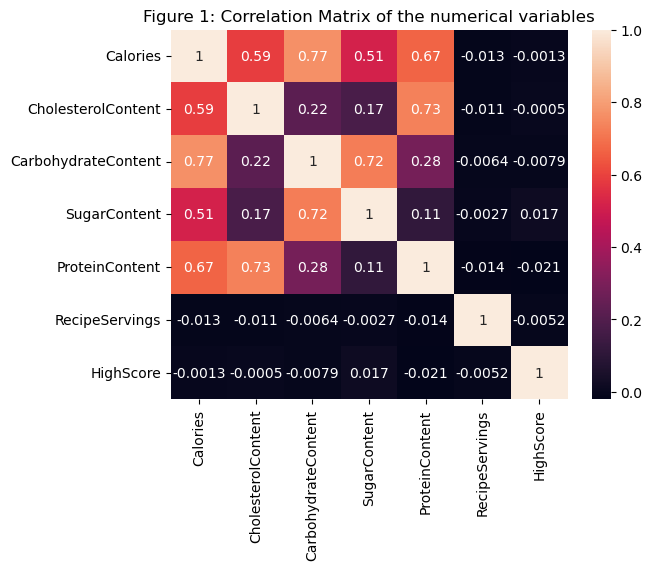

In [13]:
#Plotting the correlation matrix
sns.heatmap(data_trim[num_cols+target_col].corr(), annot=True)
plt.title('Figure 1: Correlation Matrix of the numerical variables')
plt.show()

In Figure 1 we see that there is no linear correlation between the target column 'HighScore' and feature columns, although this doesn't automatically mean there is no correlation. To get more of a definitive insight we will use more advanced visualization techniques.

To visualize the distribution of each numerical column and their dependencies within each other we will plot a seaborn pairplot. A pairplot will show a grid of graphs where, diagonally, a histogram of each variable is shown. A histogram visualizes the value of each data point on the x-axis and the number of it's occurrence on the y-axis. Left and right of the diagonal we can see the kernel distribution estimation plots(kde) of all variables plotted against each other. This is analogous to a scatter plot, but visualizes the density of data points clearer. The distance of lines in the kde-plots is proportional to the change in data point density. Similar to a topographical height map. 

In addition we color coded the data into popular(1) and unpopular(0), which is shown in the plot's legend. For the purpose of better visualization we will also get rid of high outliers, as they would distort plots in a way that would make analyzing them difficult.

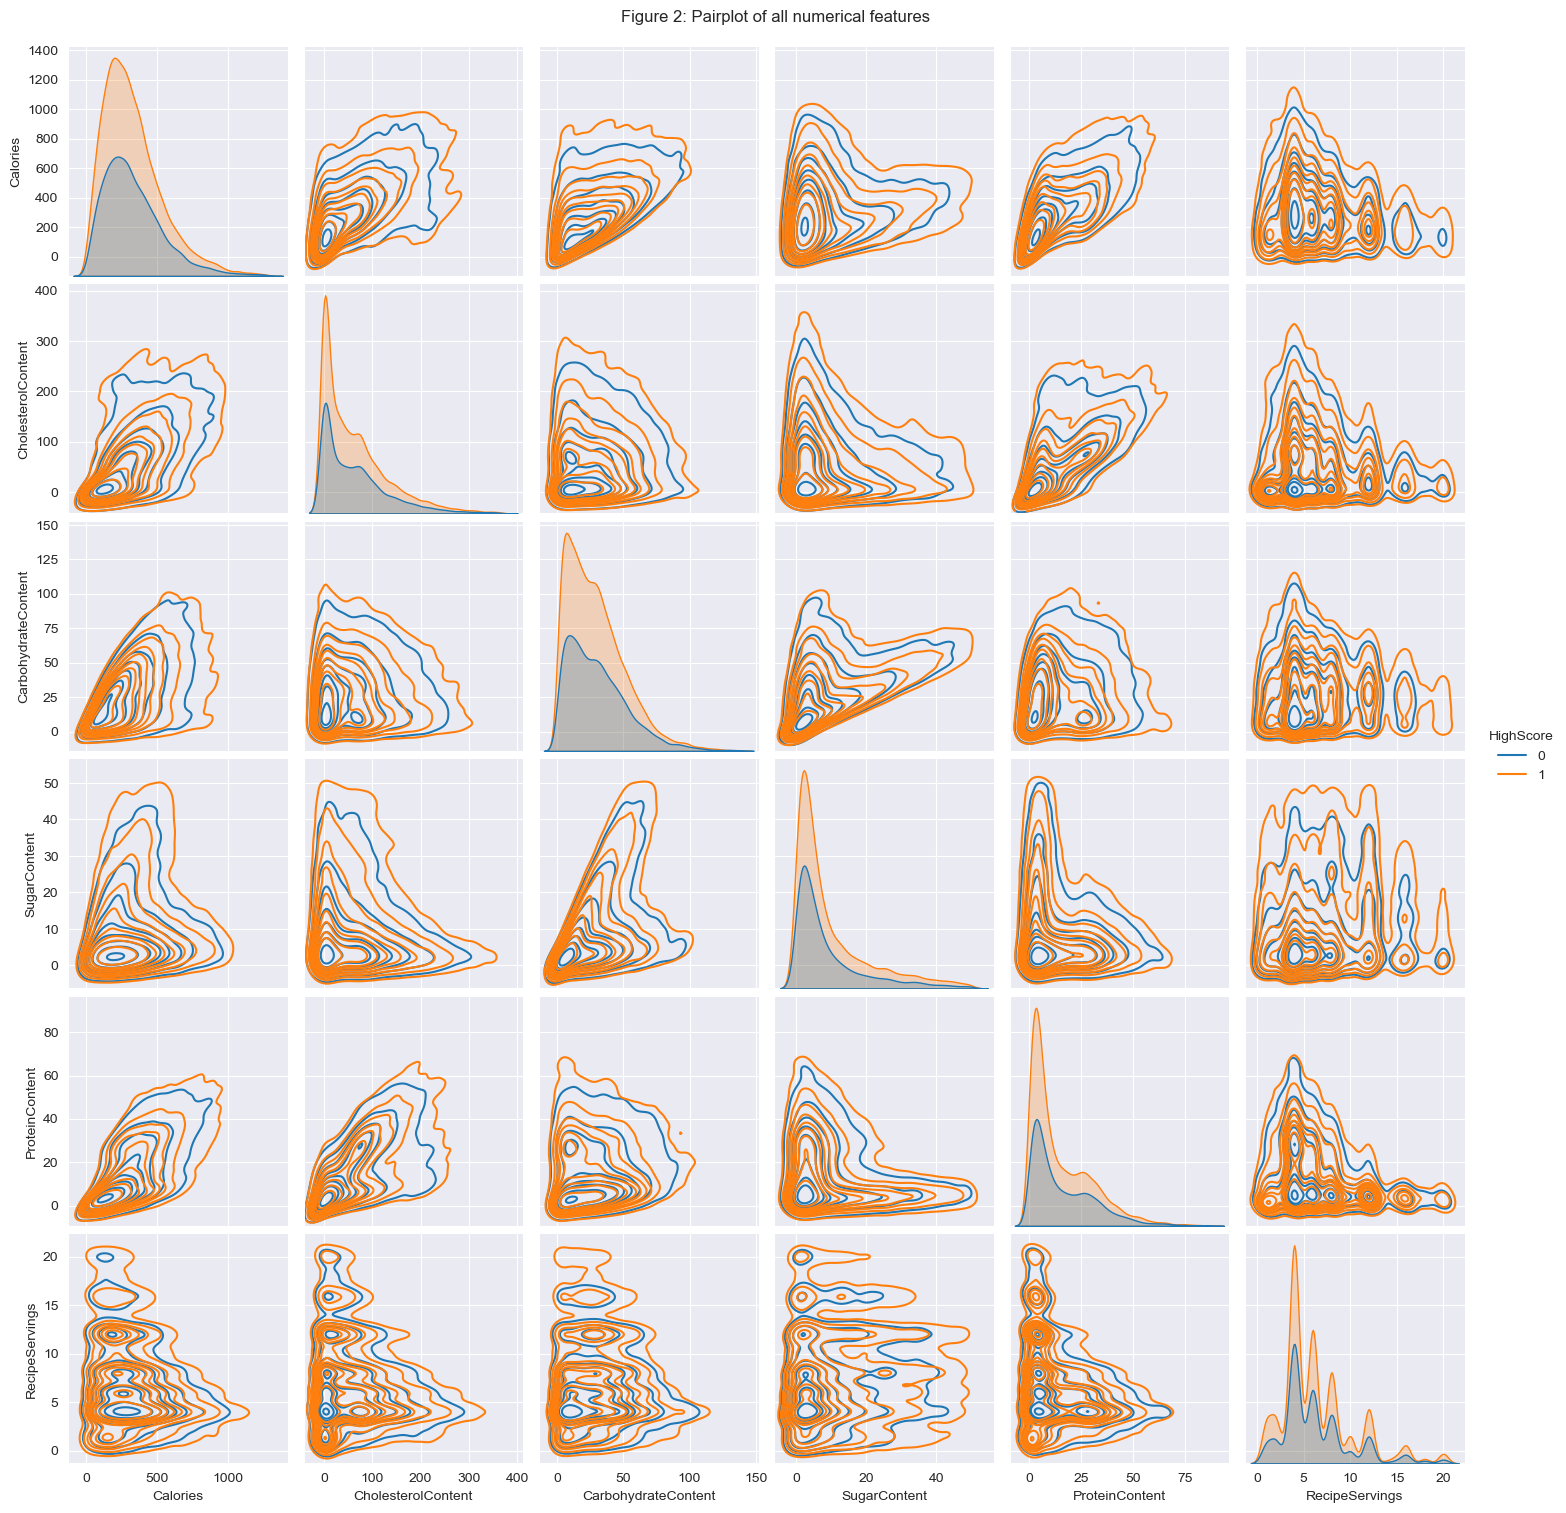

In [14]:
#Defining an empty list that will be populated by the upper bounds
upper_limits = []

#Defining the for loop that checks for outliers with IQR method
for i in num_cols:
    upper_limits.append(np.percentile(data_trim[i], 75) + 3*(np.percentile(data_trim[i], 75) - np.percentile(data_trim[i], 25)))
    
#Filtering the data for plotting
plot_data = data_trim[(data_trim[num_cols] <= upper_limits).all(axis=1)]

#Use the seaborn pairplot function to create a pairplot of the data
sns.set_style('darkgrid')
pairplot = sns.pairplot(plot_data[num_cols + ["HighScore"]], hue="HighScore", kind='kde')
pairplot.fig.suptitle('Figure 2: Pairplot of all numerical features', y=1.01)
plt.show()

Looking at Figure 2 we can immediately observe that the distribution of each numerical variable (shown in the histogram plots on the diagonal) is almost the same between popular and unpopular recipes. The difference in height of the histogram plots can be explained by the fact that popular recipes make up about 65% of all recipes and therefore the popular recipes have a higher count. Also, looking at the other plots, there doesn't seem to be a distinct difference between popular and unpopular recipe. The distribution regarding the 'HighScore,' between two features, is almost the same.

When we look at the last column of the pairplot we see the plots of all numerical data independent of the 'RecipeServings'-column. We would expect a positive linear correlation between 'Calories', 'CarbohydrateContent', 'CholesterolContent', 'SugarContent', 'ProteinContent' and 'RecipeServings', but this is not the case in this graph. One explanation could be that the 'Calories'-column doesn't describe the total amount of calories in that dish, but the calories per serving. So let's create an additional 'TotalCalories'-column.

### Creating an additional feature

In [15]:
#The total amount of calories can be calculated by multiplying 'RecipeServings' by 'Calories'
data_trim['TotalCalories'] = data_trim['Calories'] * data_trim['RecipeServings']

#Add the column to the numerical columns
num_cols_total = num_cols + ['TotalCalories']

This newly generated column now contains the total amount of calories.

To check if a relationship between 'RecipeServings' and 'TotalCalories' actually exists we are going to plot a scatter plot.

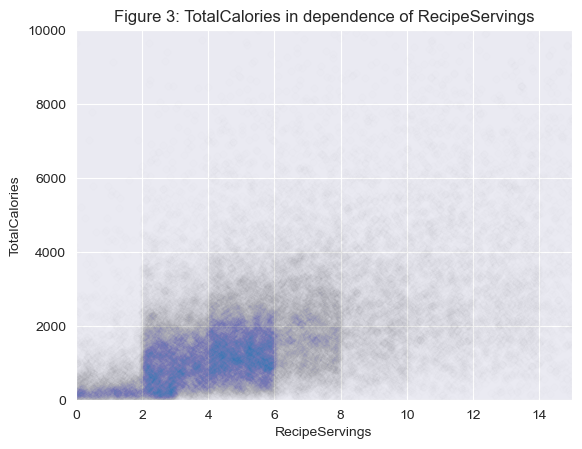

In [16]:
#Plotting the scatterplot
sns.regplot(data=data_trim, x='RecipeServings', y='TotalCalories', x_jitter=2, scatter_kws={'alpha':0.005, 's':25}, fit_reg=False)
plt.xlim(0, 15)
plt.ylim(0, 10000)
plt.title('Figure 3: TotalCalories in dependence of RecipeServings')
plt.show()

Just as expected we can now see that there is a linear relationship between 'TotalCalories' and 'RecipeServings'. The analysis of the numerical features is now finished and we can take a look at the categorical variable 'RecipeCategory'.


### Categorical Data Analysis

As we weren't able to discern between popular and unpopular recipes using visualizations of numerical data, we will now take a look at the distribution of food categories between popular and unpopular recipes. If there is any significant difference between popular and unpopular recipes, we should see a difference in the distribution of 'RecipeCategory' amongst the most popular and unpopular recipes. The following code creates two count plots side-by-side that visualize this.

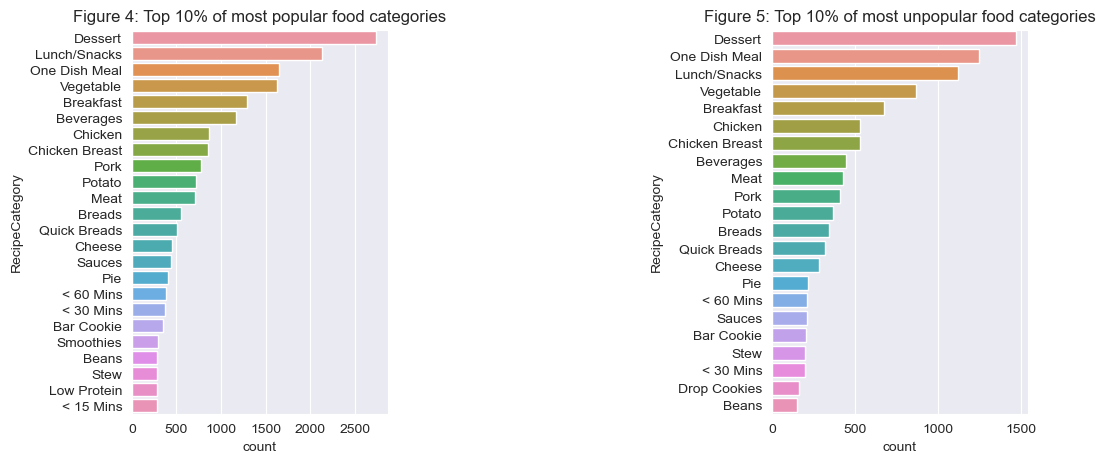

In [17]:
#Calculate the count for each popular category
category_counts_popular = data_trim[data_trim['HighScore'] == 1]['RecipeCategory'].value_counts()

#Sort the popular categories by count in descending order
sorted_category_counts_popular = category_counts_popular.sort_values(ascending=False)

#Select the top 10% of popular categories by count
top_10_percent_popular = sorted_category_counts_popular.head(round(len(category_counts_popular) * 0.1))

#Plot the top 10% of popular categories
sns.set_style('darkgrid')
plt.subplot(1, 2, 1) # row 1, col 2 index 1
g = sns.countplot(y=data_trim[data_trim['HighScore'] == 1]['RecipeCategory'], order=top_10_percent_popular.index)
plt.title('Figure 4: Top 10% of most popular food categories')


#Calculate the count for each unpopular category
category_counts_unpopular = data_trim[data_trim['HighScore'] == 0]['RecipeCategory'].value_counts()

#Sort the unpopular categories by count in descending order
sorted_category_counts_unpopular = category_counts_unpopular.sort_values(ascending=False)

#Select the top 10% of unpopular categories by count
top_10_percent_unpopular = sorted_category_counts_unpopular.head(round(len(category_counts_unpopular) * 0.1))

#Plot the top 10% of unpopular categories
sns.set_style('darkgrid')
plt.subplot(1, 2, 2) # row 1, col 2 index 1
g = sns.countplot(y=data_trim[data_trim['HighScore'] == 0]['RecipeCategory'], order=top_10_percent_unpopular.index)
plt.title('Figure 5: Top 10% of most unpopular food categories')

plt.subplots_adjust(left=0.1, bottom=0.1, right=1.5, top=0.9, wspace=1.5, hspace=0.4)
plt.show()

Again, we observe no significant difference in the distribution of most and least popular food categories. The first 5 most and least popular food categories are actually completely the same. The data behaves like the 'HighScore'-column was randomly assigned to the features.

### Randomizing the 'HighScore' column to show that the data is inherently noisy
Looking at the previous plots we suspect that the given target data  'HighScore'-column, is randomized. To prove this, we will shuffle the data in the 'HighScore'-column and observe the effects on the distributions, like in Figure 2, 4, and 5. If the shuffled data shows the same distributions we can safely assume that the original data is inherently noisy i.e. randomized.

In [18]:
#Creating a new DataFrame with a randomized 'HighScore' column
data_random = data_trim.copy()
data_random['HighScore'] = data_random['HighScore'].sample(frac=1).reset_index(drop=True)

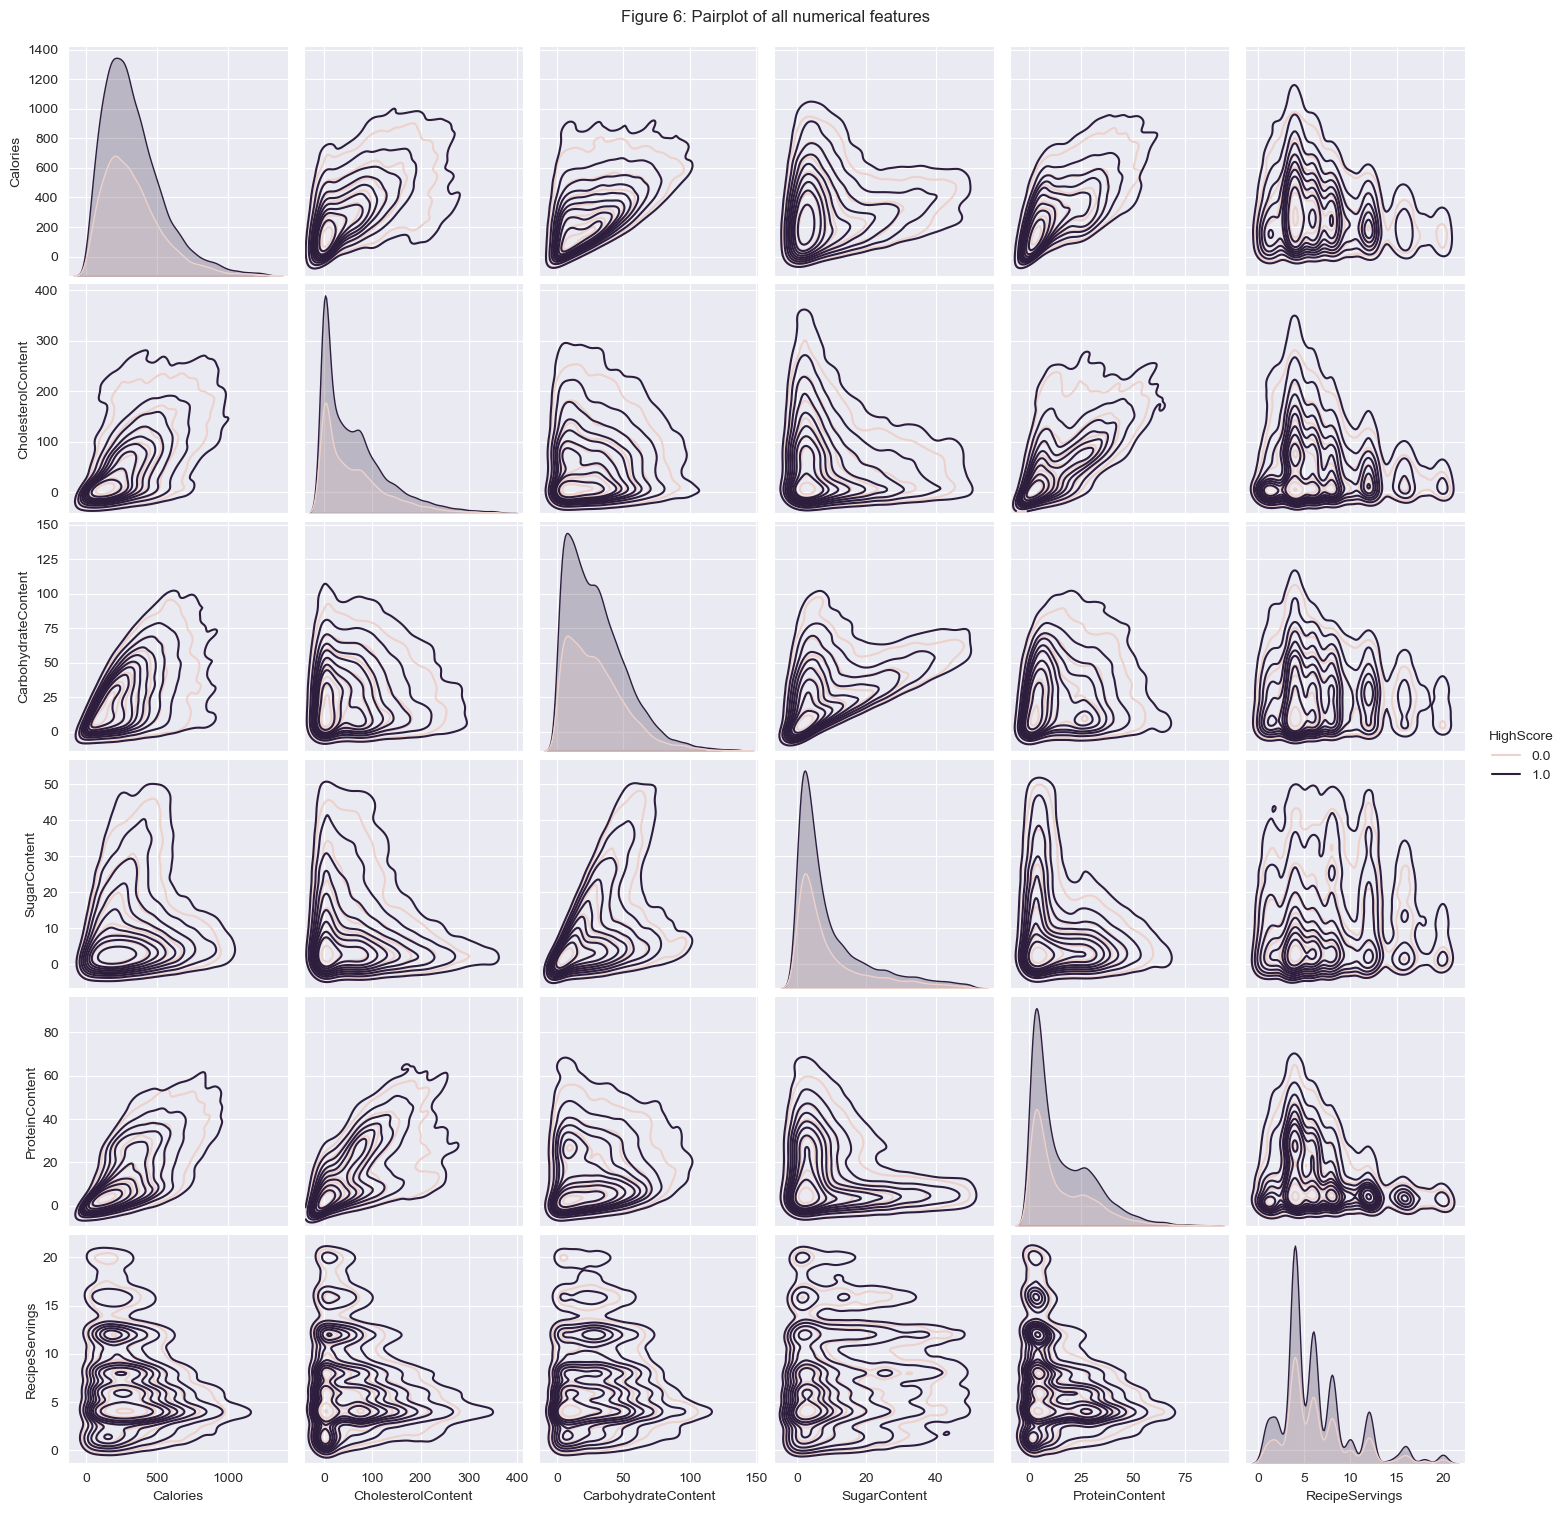

In [19]:
#Filtering the data for plotting
plot_data_random = data_random[(data_random[num_cols] <= upper_limits).all(axis=1)]

#Use the seaborn pairplot function to create a pairplot of the shuffled data
sns.set_style('darkgrid')
pairplot = sns.pairplot(plot_data_random[num_cols + ["HighScore"]], hue="HighScore", kind='kde')
pairplot.fig.suptitle('Figure 6: Pairplot of all numerical features', y=1.01)
plt.show()

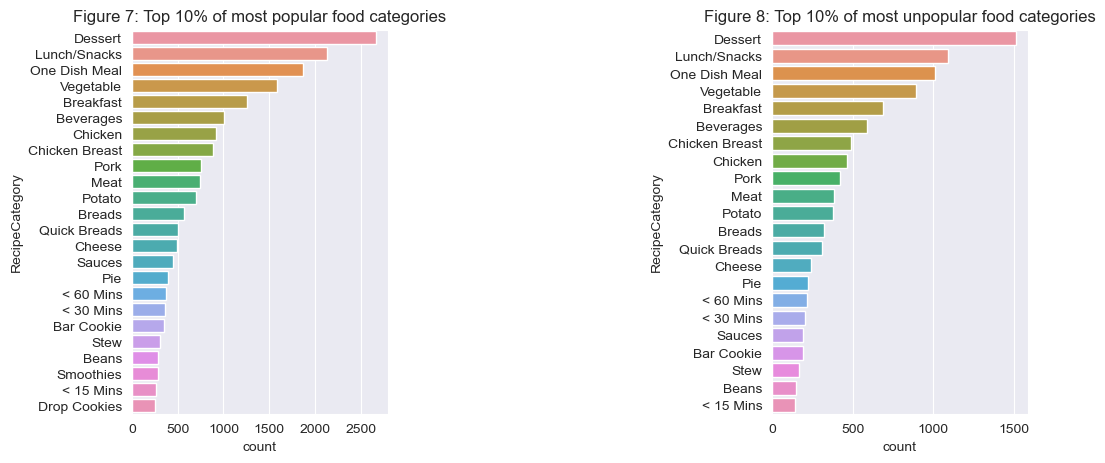

In [20]:
#Calculate the count for each popular category
category_counts_popular = data_random[data_random['HighScore'] == 1]['RecipeCategory'].value_counts()

#Sort the popular categories by count in descending order
sorted_category_counts_popular = category_counts_popular.sort_values(ascending=False)

#Select the top 10% of popular categories by count
top_10_percent_popular = sorted_category_counts_popular.head(round(len(category_counts_popular) * 0.1))

#Plot the top 10% of popular categories
sns.set_style('darkgrid')
plt.subplot(1, 2, 1) # row 1, col 2 index 1
g = sns.countplot(y=data_random[data_random['HighScore'] == 1]['RecipeCategory'], order=top_10_percent_popular.index)
plt.title('Figure 7: Top 10% of most popular food categories')



#Calculate the count for each unpopular category
category_counts_unpopular = data_random[data_random['HighScore'] == 0]['RecipeCategory'].value_counts()

#Sort the unpopular categories by count in descending order
sorted_category_counts_unpopular = category_counts_unpopular.sort_values(ascending=False)

#Select the top 10% of unpopular categories by count
top_10_percent_unpopular = sorted_category_counts_unpopular.head(round(len(category_counts_unpopular) * 0.1))

#Plot the top 10% of unpopular categories
sns.set_style('darkgrid')
plt.subplot(1, 2, 2) # row 1, col 2 index 1
g = sns.countplot(y=data_random[data_random['HighScore'] == 0]['RecipeCategory'], order=top_10_percent_unpopular.index)
plt.title('Figure 8: Top 10% of most unpopular food categories')

plt.subplots_adjust(left=0.1, bottom=0.1, right=1.5, top=0.9, wspace=1.5, hspace=0.4)
plt.show()

If we now compare figure 6,7 and 8 to the original data in figure 1, 3 and 4, we can clearly see that the distribution of feature data and the relationships between the most popular and unpopular food categories data is exactly the same. The only explanation for this would be, either the data gathered was corrupted i.e. randomized, or there exists generally no relationship between the features and target.

In the next step we will fit two ML-models to see if they can differentiate between the two 'HighScore' classes.

### Summary of all changes that have been made to the data
1. Imputed missing food categories via the 'fuzzywuzzy' package
2. Deleted all rows where the calories are either 0 and >0 in any of the other remaining numerical features

# 5. Preprocessing of numerical and categorical data
Before data can be effectively utilized by machine learning models it is best practices to scale and transform data into a usable format. Our categorical data in the 'RecipeCategory'-column has to be one-hot-encoded, to transform strings into numbers of 0 and 1, to be able to be quantified. 

Numerical data should be scaled because many models rely on calculating euclidean distance within features. Not scaling numerical data into a common scale, would lead to a model's overreliance on features that consist of larger numbers. Below, we will be using the RobustScaler package which automatically handles the outliers, by minimizing their impact on the model.

We will also put the one-hot-encoding and scaling code in a data pipeline, if more data or another dataset is used, the preprocessing steps are taken care of within the model. We won't have to to do it manually each time. In the following code we will identify feature and target columns and assign the features to different preprocessors.

In [21]:
#Now separate target data 'y',which we want to predict, and feature data X into separate DataFrames 
y = data_trim[target_col]

X = data_trim[num_cols_total + cat_cols]

#We are going to use the sklearn 'make_column_selector' to split the data into categorical and numerical data
#Initiate the selector
num_cols_selector = selector(dtype_exclude=object)
cat_cols_selector = selector(dtype_include=object)

#Split the data
num_col = num_cols_selector(X)
cat_col = cat_cols_selector(X)

#Assign columns to a specific processor. 'One-Hot-Encoding' will be used on categorical data and scaling on numerical data
cat_preprocessor = OneHotEncoder(handle_unknown="ignore")
num_preprocessor = RobustScaler()

#Now associate each of these preprocessors with their respective columns using the 'ColumnTransformer' package
preprocessor = ColumnTransformer([('one-hot-encoder', cat_preprocessor, cat_col),
                                  ('robust_scaler', num_preprocessor, num_col)])

### Split the data into train and test data
In order to avoid overfitting we will split the data into train, and test data sets. The models will be fitted with the train data set and evaluated with an unseen test data set. Additionally we introduce cross validation, which further decreases the chance that our models suffer from overfitting.

In [22]:
#Initiate the 'train_test_split'-package
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42069)

#Ininitialize KFold for cross validation of the model to prevent overfitting
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# 6. Fitting two models to the data
To fit the models, we first define an empty list which will later contain our fitted models. We then define our data pipeline, test out various hyperparameters with GridSearchCV and then finally fit our data and calculate several scoring metrics within a for loop. We will fit the models by using the f1-score as it is a robust metric for unbalanced classification tasks. Because we are dealing with a classification problem we first fit a logistic regression model, which are standard for classification, and an AdaBoosting model which represents a more sophisticated modeling approach for these type of problems. The AdaBoosting model here is based on decision tree classifiers.

In [23]:
#Initiate an empty dictionary later containing the models
models = {}

In [24]:
#Logistic Regression model
#Define the steps of the pipeline
log_steps = [('preprocessor', preprocessor), ('log', LogisticRegression(max_iter=1000))]

#Initialize the pipeline
log_pipeline = Pipeline(log_steps)

#Define dictionary of lists of hyperparameters to test out
log_parameters = {'log__solver':['liblinear', 'sag', 'saga', 'newton-cg'],
              'log__penalty': ['l1', 'l2', 'elasticnet', 'none']}

#Initialize the model
models['Logistic Regression'] = GridSearchCV(log_pipeline, param_grid=log_parameters, cv=kf, scoring='f1', n_jobs=-1)

In [25]:
#AdaBoosting model
#Define the steps of the pipeline
ada_steps = [('preprocessor', preprocessor), ('ada', AdaBoostClassifier())]

#Initialize the pipeline
ada_pipeline = Pipeline(ada_steps)

#Define dictionary of lists of hyperparameters to test out
ada_parameters = {'ada__n_estimators':[20, 50, 100, 200, 500]}

#Initialize the model
models['AdaBoosting'] = GridSearchCV(ada_pipeline, param_grid=ada_parameters, cv=kf, scoring='f1', n_jobs=-1)

In [26]:
#Initiating the scoring dictionaries
cv, accuracy, precision, recall, roc, f1 = {}, {}, {}, {}, {}, {}

#Fit all models separately and populate the scoring metrics
for key in models.keys():
    
    #Fit the classifier model
    models[key].fit(X_train, y_train)
    #Prediction
    predictions = models[key].best_estimator_.predict(X_test)
        
    #Calculate CV-Score, Accuracy, Precision, Recall and ROC-AUC-Score metrics
    cv[key] = cross_val_score(models[key].best_estimator_, X_train, y_train, cv=kf).mean()
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)
    roc[key] = roc_auc_score(y_test, models[key].best_estimator_.predict_proba(X_test)[:, 1])
    f1[key] = f1_score(predictions, y_test)

In [27]:
#Putting all scoring metrics into a DataFrame
df_model = pd.DataFrame(index=models.keys(), columns=['CV-Score', 'Accuracy', 'Precision', 'Recall', 'ROC-AUC-Score', 'F1-Score'])
df_model['CV-Score'] = cv.values()
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['ROC-AUC-Score'] = roc.values()
df_model['F1-Score'] = f1.values()

### Plotting the scoring metrics
To compare the models' performances we will plot their respective scoring metrics side-by-side.

,CV-Score,Accuracy,Precision,Recall,ROC-AUC-Score,F1-Score
Logistic Regression,0.643421,0.647416,0.994587,0.648623,0.552647,0.785185
AdaBoosting,0.643596,0.648235,0.998376,0.648424,0.547992,0.786217


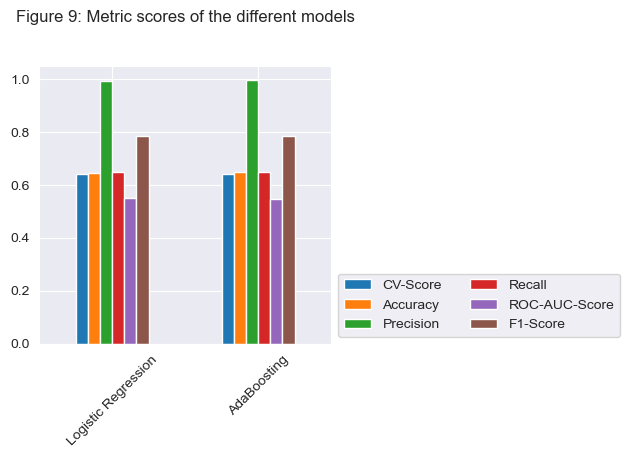

In [28]:
ax = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(1, 0), loc='lower left', prop={'size': 10})
plt.title('Figure 9: Metric scores of the different models', y=1.13)
plt.tight_layout()
display(df_model)
plt.show()

As we can see the two models have almost the same scores across all metrics. Deciding which model performed better than the other is not possible. Additionally, class 1 (popular) makes up 65% of all 'HighScore' values, so if the models' total accuracy is also 65%, this is telling that the models didn't perform better than a model that just chose class 1 in every instance. To more clearly visualize this, we will now plot the confusion matrix for the AdaBoosting model. A confusion matrix can visualize how the  predicted classes relate to the true classes.

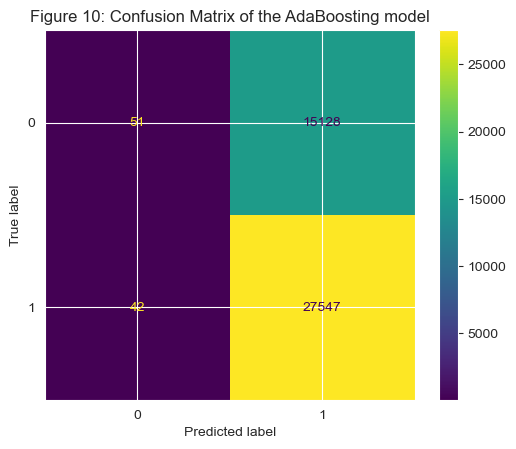

In [29]:
#Generating the confusion matrix
cm1 = confusion_matrix(y, models['AdaBoosting'].best_estimator_.predict(X), labels=models['AdaBoosting'].best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=models['AdaBoosting'].best_estimator_.classes_)

disp.plot()
plt.title("Figure 10: Confusion Matrix of the AdaBoosting model")
plt.show()

And as expected we see that our model, in almost all instances, decided to classify the recipes as class 1, which means that the model was not able to find predictable relationships between features and target. If you predict that every recipe will be popular it would be just as accurate as the model. This further underlines our assumption that the 'HighScore'-column was either randomly sampled or that there is actually no relationship between the selected features and popularity of a dish.

Although, it seems that the 'HighScore'column was randomized or that there is no relationship between the selected features and the popularity of a dish, we may be able to still help the Tasty Bytes team. 

Our strategy would be to take the remaining data that could not be classified into class 0 (25%), as stated by the owner, from the data that could be correctly classified(75%) and add it into class 1. The resulting total accuracy of this approach would be 91%. To break it down further, 75% of unpopular recipes is correctly classified which is 11,384 recipes, this leaves 3,795 recipes in the popular class 1. Assuming that the the rest of the recipes, 27,589, are popular would leave us with an overall accuracy of about 91%. 

Lets use a confusion matrix to visualize this approach.

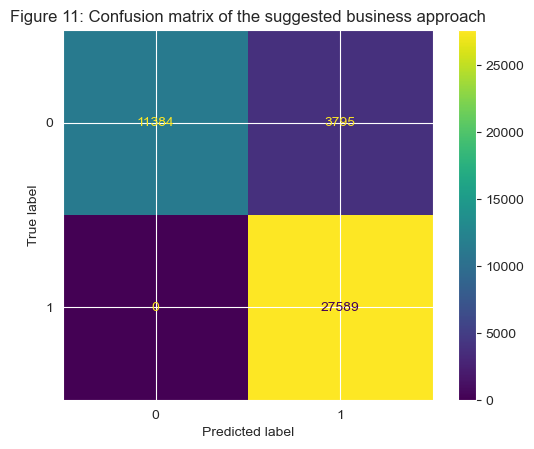

In [30]:
cm2 = np.array([[len(data_trim[data_trim['HighScore'] == 0])*0.75, len(data_trim[data_trim['HighScore'] == 0]) * 0.25],
                [0, len(data_trim[data_trim['HighScore'] == 1])]])

disp = ConfusionMatrixDisplay(np.rint(cm2))
disp.plot(values_format='g')
plt.title("Figure 11: Confusion matrix of the suggested business approach")
plt.show()

Figure 11 visualizes the best approach according to the accuracy of predicting class 0 as stated by the owner.

# Summary
To get back to the customer's initial question: With the data provided to us by the TB data team it is NOT possible to predict whether a recipe will be popular or not using information of previously published recipes.

### Regarding the success criteria
If we look at the top row of the confusion matrix(the low scoring recipes) in figure 10, the AdaBoosting model only achieved 51/15128=0.34% accuracy in predicting unpopular recipes out of all unpopular recipes, considering the 'Tasty Bytes' data team is able to predict the class 0 with an accuracy of 75%, we performed significantly worse.


### Business recommendation
Our recommendation for predicting the popular recipes is to put all recipes that can't be identified as unpopular by the owner into the popular class. That means 91% of all recipes will be correctly classified with this approach. This is visualized in figure 11.

75% of unpopular recipes could be correctly classified, as stated by the owner, which is 11,346 recipes, this leaves 3,782 recipes in the popular class 1. Assuming that the the rest of the recipes, 27,589, are popular would leave us with an overall accuracy of about 91%. That means 91% of all recipes will be correctly classified with this approach. 

Our recommendation for the data team for creating a more accurate model would be to include more detailed information about each recipe, like ingredients etc. or providing datetime information about the upload, as internet traffic is highly correlated to time and certain recipes are more popular around Christmas, Thanksgiving etc.. Furthermore we recommend taking a look at the data in the 'HighScore'-column as it seems like that the data has been corrupted by randomization.